In [1]:
#using Pkg
#Pkg.add("Images")
#Pkg.add("MAT")


using MAT
using Plots
using Images


pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

In [1]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
#using Pkg
#Pkg.add("ImageIO")
#Pkg.add("ImageMagick")

using ImageIO
using ImageMagick

p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

LoadError: ArgumentError: Package ImageIO not found in current path:
- Run `import Pkg; Pkg.add("ImageIO")` to install the ImageIO package.


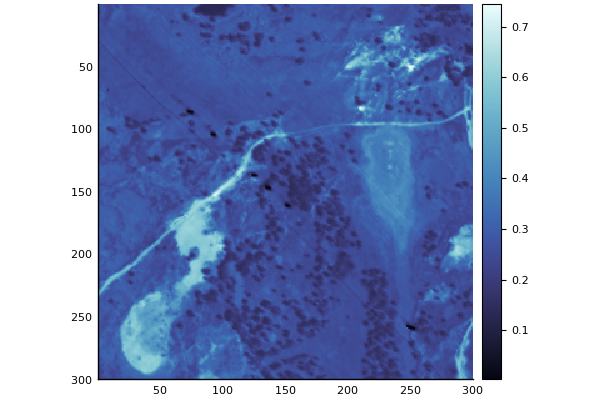

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [3]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

In [2]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")


LoadError: UndefVarError: sources not defined

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [2]:
using LinearAlgebra
img_small = img[1:100,1:100,:]; # use a small crop of the image first
# img_small = copy(img);
#print(size(img_small))
    

h = size(img_small)[1]
w = size(img_small)[2]
N = h*w
L = size(img_small)[3]
P = size(sources)[2]

X = zeros(L, N)
for i=1:h
    for j=1:w
        for k in 1:L
            X[k, (i-1)*w+j] = img_small[i,j,k]
        end
    end
end

In [3]:
function pixel_loss(x, a)
    return 0.5*norm(x - sources*a)^2
end

function gradient_for_one_pixel(n, step, delta_error, nb_max_iter, normalize)
    x = X[:, n]#sperctrum at pixel n
    a = (1/P)*ones(P, 1)
    old_error = 10^2
    stop = false
    i = 0
    while i < nb_max_iter && !stop
        a = a + step*(transpose(sources)*(x - sources*a)) 
        for p in 1:P
            if a[p]<0
                a[p] = 0
            end
        end
        if normalize
            a /= sum(a)
        end
        new_error = pixel_loss(x, a)
        stop = (abs(new_error-old_error) < delta_error)
        old_error = new_error
        i += 1
        #print(old_error)
        #print("\n")
    end
    return a, x, old_error
        
end

gradient_for_one_pixel (generic function with 1 method)

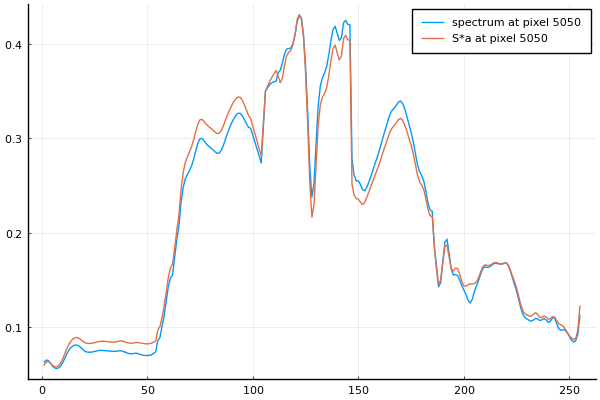

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [7]:
#plot!(x, label = "spectrum at pixel 10")
pixel = 5050
a, x, old_error = gradient_for_one_pixel(pixel, 0.01, 10^-4, 1000, true)
plot(x, label = "spectrum at pixel $pixel")
plot!(sources*a, label = "S*a at pixel $pixel")

In [4]:
pixel = 5050
a, x, old_error = gradient_for_one_pixel(pixel, 0.01, 10^-4, 1000, true)
gravel, grass, soil, trees = a
i = div(pixel, h)
j = pixel%h
print("components at pixel 6020 , coordinate $i , $j in the image are \n")
print("gravel $gravel \n")
print("grass  $grass \n")
print("soil $soil \n")
print("trees  $trees \n")
print("error found : $old_error")


components at pixel 6020 , coordinate 50 , 50 in the image are 
gravel 0.001690401907809595 
grass  0.017186016822434882 
soil 0.8508466157367695 
trees  0.13027696553298598 
error found : 0.010463048861377316

In [5]:
A = zeros(P, N)
for n in 1:N
    a, _, _ = gradient_for_one_pixel(n, 0.01, 10^-4, 1000, true)
    A[:, n] = a
end
error = norm(X-sources*A)^2
print("error over all the pixels $error")

error over all the pixels 3470.5889058431057

In [6]:
using Distributed

CPU_CORES = 4 # number of cores on the machine

# Before adding workers.
nprocs()
nworkers() # when there are no no extra workers, nprocs() = nworkers().

# After adding them.
addprocs(CPU_CORES - 1) # 4 cores
# addprocs(1) # 2 cores
nprocs()
nworkers()
workers()

3-element Array{Int64,1}:
 2
 3
 4

In [41]:
for w in 1:4
    @spawnat w sources
    @spawnat w img_small
    @spawnat w X
    @spawnat w h
    @spawnat w w
    @spawnat w N
    @spawnat w L
    @spawnat w P
end

@everywhere using LinearAlgebra: norm

@everywhere function pixel_loss(x, a)
    return 0.5*norm(x - sources*a)^2
end

@everywhere function gradient_for_one_pixel(n, step, delta_error, nb_max_iter, normalize)
    x = X[:, n]#sperctrum at pixel n
    a = (1/P)*ones(P, 1)
    old_error = 10^2
    stop = false
    i = 0
    while i < nb_max_iter && !stop
        a = a + step*(transpose(sources)*(x - sources*a)) 
        for p in 1:P
            if a[p]<0
                a[p] = 0
            end
        end
        if normalize
            a /= sum(a)
        end
        new_error = pixel_loss(x, a)
        stop = (abs(new_error-old_error) < delta_error)
        old_error = new_error
        i += 1
        #print(old_error)
        #print("\n")
    end
    return a, x, old_error
        
end


function gradient_sequential(step, delta_error, nb_max_iter, normalize)
    A = zeros(P, N)
    for n in 1:N
        a, _, _ = gradient_for_one_pixel(n, step, delta_error, nb_max_iter, normalize)
        A[:, n] = a
    end
    return A
end

function gradient_parallel(step, delta_error, nb_max_iter, normalize)
    for w in 1:4
        @spawnat w step
        @spawnat w delta_error
        @spawnat w nb_max_iter
        @spawnat w normalize
    end
    @everywhere function f(n)
        #gradient_for_one_pixel(n, step, delta_error, nb_max_iter, normalize)
        gradient_for_one_pixel(n, 0.01, 10^-4, 1000, true)
    end
    return pmap(f, collect(1:N))
end

gradient_parallel (generic function with 1 method)

In [43]:
@time gradient_sequential(0.01, 10^-4, 1000, true)
@time gradient_parallel(0.01, 10^-4, 1000, true)

 10.783642 seconds (14.64 M allocations: 4.960 GiB, 9.80% gc time)
  7.167678 seconds (791.04 k allocations: 47.205 MiB)


10000-element Array{Tuple{Array{Float64,2},Array{Float64,1},Float64},1}:
 ([0.13578546154533136; 0.29642508097219367; 0.24249238441857796; 0.32529707306389705], [0.06489378958940506, 0.06817302107810974, 0.06903893500566483, 0.06738359481096268, 0.06486763060092926, 0.06303811073303223, 0.06265399605035782, 0.06408780813217163, 0.06762102246284485, 0.07334568351507187  …  0.09550725668668747, 0.09742650389671326, 0.10163954645395279, 0.10156437754631042, 0.09753446280956268, 0.09288200736045837, 0.08972993493080139, 0.08919317275285721, 0.09499267488718033, 0.11413560062646866], 0.2546811026306533)
 ([0.143869328506522; 0.2946485116119965; 0.23884705248042343; 0.32263510740105805], [0.061990395188331604, 0.06550440192222595, 0.06630674749612808, 0.06444576382637024, 0.06177978962659836, 0.059806227684020996, 0.05924329161643982, 0.06053869426250458, 0.06406131386756897, 0.06997207552194595  …  0.09912224858999252, 0.10041698813438416, 0.10227897018194199, 0.10041996091604233, 0.0958731